In [6]:
import matplotlib.pyplot as plt

import jax
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_debug_nans', True)
import jax.numpy as jnp

from jax.random import split

from bilby_util import convert_bilby_uniform_prior

from astro import calc_chieff
from astro import get_merging_binary

from flows import bounded_to_reals
from flows import default_flow
from variational import fit
from variational import estimate_convergence

from util import plot_loss
from util import plot_multiple


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# attempts to sample in $\chi_{\rm eff}$

In [2]:
param_keys, bounds, log_prior = convert_bilby_uniform_prior('./kick-prog.prior')

In [3]:
prog_param_keys = [
    'mbhmax',
    'mturnover',
    'sigma_mbh',
    'alpha_prog_1',
    'alpha_prog_2',
    'sigma_kick'
]

In [4]:
prog_param_bounds = jnp.stack([
    bounds[param_keys.index(k)]
    for k in prog_param_keys
])

In [ ]:
def get_hyper_and_binary(key):
    key, subkey = split(key)
    c = jax.random.uniform(subkey)
    c = (
        c * (prog_param_bounds[:, 1] - prog_param_bounds[:, 0])
        + prog_param_bounds[:, 0]
    )

    parameters = dict(zip(prog_param_keys, c))
    binary = get_merging_binary(key, parameters)

    mbh1, mbh2 = binary['mbh1'], binary['mbh2']
    mbh2, mbh1 = jnp.sort(jnp.stack((mbh1, mbh2)), axis=0)

    mass_ratio = mbh2 / mbh1
    chi_eff = calc_chieff(mass_ratio, )
    

    c = bounded_to_reals(c, prog_param_bounds)
    return cos_tau, c

# attempts to sample in cosine-spin tilts

## This is wrong, **but** ...

For simplicity, I'm going to learn two different flows; one for black hole primary mass and mass ratio, and one for cos tilt.
When we combine these during inference, we'll implicitly assume that these distributions are independent (even though they aren't, really).
This is so that we can make another (incorrect) assumption for simplicity; that $cos \tau_1$ and $\cos \tau_2$ are i.i.d.

### failed attempt with flows and other things

In [ ]:
prog_param_keys = [
    'mbhmax',
    'mturnover',
    'sigma_mbh',
    'alpha_prog_1',
    'alpha_prog_2',
    'sigma_kick'
]

In [ ]:
from flowjax.bijections.bijection import AbstractBijection
from flowjax.distributions import Transformed
from flowjax.distributions import StandardNormal

import equinox as eqx

class TrainableAffine(AbstractBijection):
    r"""Elementwise affine transformation :math:`y = a \cdot x + b`.

    ``loc`` and ``scale`` should broadcast to the desired shape of the bijection.
    By default, we constrain the scale parameter to be postive using ``softplus``, but
    other parameterizations can be achieved by replacing the scale parameter after
    construction e.g. using ``eqx.tree_at``.

    Args:
        loc: Location parameter. Defaults to 0.
        scale: Scale parameter. Defaults to 1.
    """

    shape: tuple[int, ...]
    cond_shape: tuple[int, ...]
    net: eqx.nn.MLP

    def __init__(self, key, shape, cond_shape, width: int = 5, depth: int = 2):
        self.shape = shape
        self.cond_shape = cond_shape
        self.net = eqx.nn.MLP(
            key=key,
            in_size=self.cond_shape[0],
            out_size=2,
            width_size=width,
            depth=depth,
            activation=jax.nn.elu
        )

    def get_loc_and_scale(self, condition):
        loc, scale = self.net(condition)
        scale = jax.nn.sigmoid(scale) #jax.nn.softplus(scale)
        return loc, scale

    def transform_and_log_det(self, x, condition=None):
        loc, scale = self.get_loc_and_scale(condition)
        return x * scale + loc, jnp.log(jnp.abs(scale)).sum()

    def inverse_and_log_det(self, y, condition=None):
        loc, scale = self.get_loc_and_scale(condition)
        return (y - loc) / scale, -jnp.log(jnp.abs(scale)).sum()
    
def get_trainable_normal(key, shape, cond_shape, **kwargs):
    bijection = TrainableAffine(key, shape, cond_shape, **kwargs)
    base_dist = StandardNormal(shape)
    return Transformed(base_dist, bijection)

cos_tau_prior_init = get_trainable_normal(jax.random.key(2), (1,), (len(prog_param_keys),))

In [ ]:
from flows import default_flow

cos_tau_prior_init = default_flow(
    jax.random.key(2),
    [ None ],
    flow_layers=2,
    nn_depth=10,
    nn_block_dim=8,
    cond_dim=len(prog_param_keys),
    invert=True
)

In [ ]:
param_keys, bounds, log_prior = convert_bilby_uniform_prior('./kick-prog.prior')

In [ ]:
prog_param_bounds = jnp.stack([
    bounds[param_keys.index(k)]
    for k in prog_param_keys
])

In [ ]:
def project_hyper_params_to_real(c):
    return jax.scipy.special.logit(
        (c - prog_param_bounds[:, 0]) / (prog_param_bounds[:, 1] - prog_param_bounds[:, 0])
    )

In [ ]:
def get_merging_binary(key, parameters):
    def cond(carry):
        _, binary = carry
        return ~jnp.logical_and(binary['survive'], binary['merge'])

    def body(carry):
        key, _ = carry
        key, subkey = split(key)
        return key, get_sample(subkey, parameters)

    init = body((key, None))
    _, binary = jax.lax.while_loop(cond, body, init)
    return binary

In [ ]:
def get_joint_tau_hyper_sample(key):
    """ draw a hyperparameter sample; then draw cos_tau """
    key, subkey = split(key)
    c = jax.random.uniform(subkey)
    c = (
        c * (prog_param_bounds[:, 1] - prog_param_bounds[:, 0])
        + prog_param_bounds[:, 0]
    )

    parameters = dict(zip(prog_param_keys, c))
    binary = get_merging_binary(key, parameters)

    cos_tau = jnp.array([binary['cos_theta']])
    cos_tau = jnp.clip(
        cos_tau,
        min=-1 + 1e-15,
        max=1 - 1e-15
    )

    # project from bounded to real line
    c = project_hyper_params_to_real(c)
    return cos_tau, c

In [ ]:
keys = split(jax.random.key(1702), 10_000_000)
xs, cs = jax.lax.map(get_joint_tau_hyper_sample, keys, batch_size=1_000_000)

In [ ]:
xs = jnp.arctanh(xs)

In [ ]:
def get_sample_for_training(key):
    i = jax.random.choice(key, 10_000_000)
    return xs[i], cs[i]

In [ ]:
import optax
from sbi import train as train_sbi

lr = 1e-3
steps = 10_000 

learning_rate = optax.warmup_cosine_decay_schedule(
    init_value=lr,
    peak_value=lr,
    warmup_steps=0,
    decay_steps=steps,
    end_value=lr
)

optimizer = optax.adam(learning_rate=learning_rate)

cos_tau_prior, loss_tau = train_sbi(
    jax.random.key(5),
    cos_tau_prior_init,
    get_sample_for_training, #get_joint_tau_hyper_sample,
    steps,
    optimizer,
    batch_size=100, #50_000
)

train: 100%|██████████| 10000/10000 [00:00<00:00, 11083.89it/s]


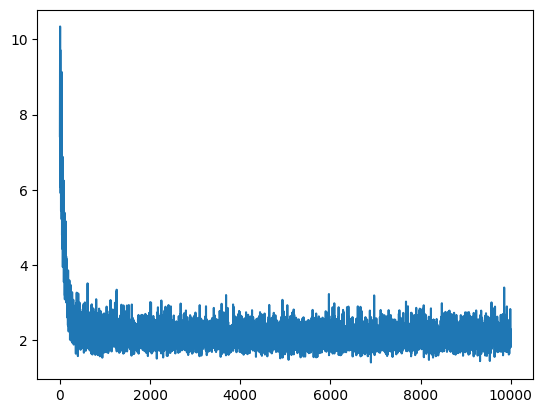

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(steps), loss_tau)

Deleted a few plots here, showing that the flow struggles to fit extremley peaky distributions.

## okay, new approach .. what if we draw a bunch of binaries for each pair of hyperparameters and fit a KDE?

Nvm, this takes forever to sample --- ~4 s / likelihood evaluation!
Can't use VI either b/c we can't reverse-mode differentiate through `jax.lax.while_loop`

In [9]:
mmin_abs = 1 # a ridiculous number, but just for testing
mmax_abs = 300

def get_merging_binary(key, parameters):
    def cond(carry):
        _, binary = carry
        return ~jnp.logical_and(binary['survive'], binary['merge'])

    def body(carry):
        key, _ = carry
        key, subkey = split(key)
        return key, get_sample(subkey, parameters)

    init = body((key, None))
    _, binary = jax.lax.while_loop(cond, body, init)
    return binary

def kick_tilt_and_mass_model(parameters):
    #key, subkey = split(key)
    # TODO: is it kosher to use the same key everytime?
    keys = split(jax.random.key(746566), 10_000)
    binaries = jax.vmap(lambda k: get_merging_binary(k, parameters))(keys)

    cos_tau = jnp.clip(
        binaries['cos_theta'], min=-1 + 1e-15, max=1 - 1e-15
    )
    arctanh_cos_tau = jnp.arctanh(cos_tau)

    # TODO: fit with kde!
    kde_atanh_cos_tau = jax.scipy.stats.gaussian_kde(arctanh_cos_tau)

    def p_cos_tau(cos_tau):
        cos_tau = jnp.clip(cos_tau, min=-1 + 1e-15, max=1 - 1e-15)
        p_atanh_cos_tau = kde_atanh_cos_tau(jnp.arctanh(cos_tau))
        return p_atanh_cos_tau / (1 - cos_tau**2)
    
    mbh1, mbh2 = binaries['mbh1'], binaries['mbh2']
    # sort by mass
    #mbh1, mbh2 = mbh1, mbh2 if mbh2 < mbh1 else mbh2, mbh1
    mbh2, mbh1 = jnp.sort(jnp.stack((mbh1, mbh2)), axis=0)

    lnq = jnp.log(mbh2 / mbh1)
    mbh1_tilde = jax.scipy.special.logit(
        jnp.clip(
            (mbh1 - mmin_abs) / (mmax_abs - mmin_abs),
            min=1e-6,
            max=1 - 1e-6
        )
    )

    kde_m1lnq = jax.scipy.stats.gaussian_kde(jnp.stack((mbh1_tilde, lnq)))

    def p_m1_q(mass_1, mass_ratio):
        log_mass_ratio = jnp.log(mass_ratio)
        y = jnp.clip(
            (mass_1 - mmin_abs) / (mmax_abs - mmin_abs),
            min=1e-6,
            max=1 - 1e-6
        )
        mass_1_tilde = jax.scipy.special.logit(y)
        p_m1_lnq = kde_m1lnq(jnp.stack((mass_1_tilde, log_mass_ratio)))

        dlnq_dq = 1 / mass_ratio
        dm1tilde_dm1 = (1 / y + 1 / (1 - y)) / (mmax_abs - mmin_abs)

        return p_m1_lnq * jnp.abs(dlnq_dq * dm1tilde_dm1)

    return p_cos_tau, p_m1_q


In [10]:
from pixelpop.models.gwpop_models import PowerlawPlusPeak_MassRatio
from pixelpop.models.gwpop_models import BrokenPowerlawPlusTwoPeaks_PrimaryMass

def o4a_like_mass_model(dataset, parameters):
    lam_tilde_0 = parameters['lam_tilde_0']
    lam_tilde_1 = parameters['lam_tilde_1']
    lam_tilde_2 = parameters['lam_tilde_2']

    norm = lam_tilde_0 + lam_tilde_1 + lam_tilde_2
    parameters['lam0'] = lam_tilde_0 / norm
    parameters['lam1'] = lam_tilde_1 / norm
    parameters['lam2'] = lam_tilde_2 / norm

    #p_m1qzmag = bplm1q_plz_truncnormmag(dataset, parameters)

    log_p_m1 = BrokenPowerlawPlusTwoPeaks_PrimaryMass(
        dataset,
        alpha_1=parameters['alpha1'],
        alpha_2=parameters['alpha2'],
        mmin=parameters['mmin'],
        break_mass=parameters['mbreak'],
        delta_m_1=parameters['delta_m'],
        lam_fractions=[
            parameters['lam0'],
            parameters['lam1'],
            parameters['lam2']
        ],
        mpp_1=parameters['mpp1'],
        sigpp_1=parameters['sigpp1'],
        mpp_2=parameters['mpp2'],
        sigpp_2=parameters['sigpp2'],
    )
    p_m1 = jnp.exp(log_p_m1)

    log_p_q = PowerlawPlusPeak_MassRatio(
        dataset,
        slope=parameters['beta'],
        minimum=parameters['mmin'],
        delta_m=parameters['delta_m']
    )
    p_q = jnp.exp(log_p_q)

    return p_m1 * p_q

In [11]:
def full_tilt_and_mass_model(dataset, parameters):
    xi_spin = parameters['xi']

    calc_p_kick_tilt, calc_p_kick_mass = kick_tilt_and_mass_model(parameters)

    p_kick_tilt = jax.vmap(calc_p_kick_tilt)(dataset['cos_tilt_1'])
    p_kick_tilt *= jax.vmap(calc_p_kick_tilt)(dataset['cos_tilt_2'])

    p_kick_m1q = jax.vmap(lambda x: calc_p_kick_mass(x[0], x[1]))((dataset['mass_1'], dataset['mass_ratio']))

    p_iso_tilt = 1 / 4
    p_iso_m1q = o4a_like_mass_model(dataset, parameters)
 
    return (1 - xi_spin) * p_iso_tilt * p_iso_m1q + xi_spin * p_kick_tilt * p_kick_m1q

In [25]:
from models import truncnorm
from models import log_powerlaw_redshift

def model_kick(dataset, parameters):
    parameters['sigma_kick'] = jnp.exp(parameters['log_sigma_kick'])

    log_p_z = log_powerlaw_redshift(dataset, parameters)
    p_z = jnp.exp(log_p_z)

    p_a1 = truncnorm(
        dataset['a_1'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )
    p_a2 = truncnorm(
        dataset['a_2'],
        parameters['mu_chi'],
        parameters['sigma_chi'],
        high=1,
        low=0
    )

    p_tilt = full_tilt_and_mass_model(dataset, parameters)

    return p_z * p_a1 * p_a2 * p_tilt

In [26]:
import pickle

datadir = '/n/netscratch/iaifi_lab/Lab/newolfe/tilts-and-kicks'
with open(f'{datadir}/posteriors.pkl', 'rb') as f:
    posteriors = pickle.load(f)

posteriors = {k : jnp.array(v) for k, v in posteriors.items()}

with open(f'{datadir}/injections.pkl', 'rb') as f:
    injections = pickle.load(f)

injections = {k : jnp.array(v) for k, v in injections.items()}

In [ ]:
import bilby
import numpy as np
from bilby_util import LikelihoodWrapper
from likelihood import taper

priors = bilby.core.prior.ConditionalPriorDict('kick-prog.prior')
priors['xi'].maximum = 0.1 # mahybe variance blows up when this is too large b/c the disrtribution is too peaky?
priors.pop('sigma_kick')

priors['log_sigma_kick'] = bilby.core.prior.Uniform(
    minimum=np.log(1e4), # ln(10 / km/s),
    maximum=np.log(1e6), # ln(1000 / km / s)
)

bilby_likelihood = LikelihoodWrapper(
    posteriors=posteriors,
    injections=injections,
    density=model_kick,
    taper=lambda v: taper(4, v),
    rate=False
)
bilby_likelihood.parameters.update(priors.sample())
print('log like ratio: ', bilby_likelihood.log_likelihood_ratio())

log like ratio:  -5080.294381658539


In [28]:
jax.config.update('jax_debug_nans', False)

In [ ]:
bilby.core.utils.random.seed(1)
result = bilby.run_sampler(
    likelihood=bilby_likelihood,
    priors=priors,
    outdir='./runs/01-inference-with-survival/nest-16oct25',
    sampler='dynesty',
    nlive=50,
    label='dynesty',
    save='hdf5',
    resume=False
)

21:05 bilby INFO    : Running for label 'dynesty', output will be saved to './runs/01-inference-with-survival/nest-16oct25'


we can't use variational inference b/c we can't reverse-mode differentiate through `while_loop` :(

In [ ]:
maximum_variance = 1

def log_likelihood(parameters):
    parameters = dict(zip(param_keys, parameters))
    lkl, var, _, _, _ = shape_ln_likelihood_and_variance(
        posteriors, injections, model_kick, parameters
    )
    return lkl, var


def log_posterior(parameters):
    lkl, var = log_likelihood(parameters)
    return lkl + taper(maximum_variance, var) + log_prior(parameters)

In [ ]:
flow_init = default_flow(jax.random.key(1), bounds)

Variational inference allows us to get a represenative (though not fully converged) estimate of the population posterior with only $10^4$ likelihood evaluations.

In [ ]:
flow, loss = fit(jax.random.key(2), flow_init, log_posterior, steps=10, batch_size=10)

ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop with dynamic start/stop values. Try using lax.scan, or using fori_loop with static start/stop.

Loss curve of variational inference -- lower is better, although we don't have the evidence $Z$ a-priori, so it won't go to zero. Instead, it should plateau at some value $\sim -\ln Z$.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

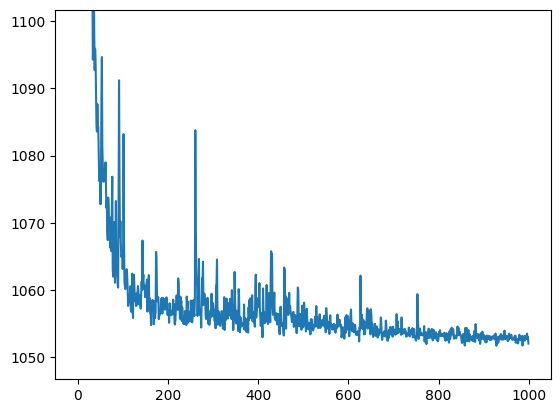

In [ ]:
plot_loss(loss, zoom=True)